In [1]:
from google.colab import drive
import os
import sys
drive.mount('/content/drive/')

Mounted at /content/drive/


In [21]:
cls_filepath ="drive/MyDrive/NLU Coursework/" #Path to the directory containing the classes folder

model_filepath = "drive/MyDrive/NLU Coursework/solution_C/models_C/solution_C.pt" #Path to the model to be demoed
dataset_path = "drive/MyDrive/NLU Coursework/data/training_data/training_data/NLI/dev.csv" #Path to the dataset used for evaluation
labels_path = "drive/MyDrive/NLU Coursework/submissions/Group_17_C.csv" #Path to output the predicted labels

# Evaluation Setup

In [3]:
sys.path.append(cls_filepath) #Path to import the helper methods & classes from. Classes directory must be within this folder
from classes.evaluation import evaluate, draw_confusion_matrix, most_confused_samples
from classes.preprocessing import load_data_csv

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [4]:
import torch
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from torch.utils.data import TensorDataset, DataLoader
from keras.utils import to_categorical

In [5]:
import json
from random import randint
import os
import random
from nltk.corpus import wordnet, stopwords
from itertools import chain
import nltk
import typing
import numpy as np
import pandas as pd

## Functions

In [6]:
def tokenize_data(tokenizer: RobertaTokenizer, premises: typing.List[str], hypotheses: typing.List[str], maxlen: int) ->typing.Tuple[np.array, np.array]:
  """
  Uses the input tokenizer to tokenizer the premises & hypotheses together. Will padd/truncate the sequences of tokens correctly. Formats the sequences together of the format below

      sample = [CLS] Premise [SEP] Hypothesis [SEP]
  """
  return tokenizer(premises, hypotheses, max_length=maxlen, padding="max_length", truncation=True, return_tensors="pt", add_special_tokens=True)

## Variables

In [7]:
INPUTS_IDS_KEY: str = "input_ids"
ATTENTION_MASK_KEY: str = "attention_mask"
TOKEN_TYPE_KEY: str = "token_type_ids"

In [8]:
NUM_LABELS = 2

# Data Preprocessing

## Load Data

In [9]:
premises, hypotheses, true = load_data_csv(filepath=dataset_path)

In [10]:
premises_og = premises
hypotheses_og = hypotheses

In [11]:
true = [int(x) for x in true]
labels = torch.tensor(true)

### Example

In [12]:
index = randint(0, len(premises))
print(f"Premise: {premises[index]}")
print(f"Hypothesis: {hypotheses[index]}")
print(f"Label: {labels[index]}")

Premise: Choices about federal spending for infrastructure, education, and R&amp;D as well as tax incentives for private saving and investment also have implications for future economic growth.
Hypothesis: Education spending mostly goes into purchasing better desks for teachers and students.
Label: 1


## Tokenize Data

In [13]:
BERT_ID: str = 'roberta-base'
tokenizer = RobertaTokenizer.from_pretrained(BERT_ID, do_lower_case=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [14]:
demo_data = tokenize_data(tokenizer=tokenizer, premises=list(premises), hypotheses=list(hypotheses), maxlen=512)

In [15]:
VOCAB_SIZE = tokenizer.vocab_size
print(f"Vocabulary size: {VOCAB_SIZE}")

Vocabulary size: 50265


### Example

In [16]:
print(f"Sentence: {tokenizer.convert_ids_to_tokens(demo_data[INPUTS_IDS_KEY][0])}")
print(f"Tokens: {demo_data[INPUTS_IDS_KEY]}")

Sentence: ['<s>', 'Mon', 'ĠDie', 'u', '!', 'Ġ', '</s>', '</s>', 'This', 'Ġperson', 'Ġis', 'Ġspeaking', 'ĠEnglish', '.', '</s>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>',

## Format Dataset & Dataloader

In [17]:
dataset = TensorDataset(demo_data[INPUTS_IDS_KEY], demo_data[ATTENTION_MASK_KEY], labels) #note here that the dev dataset is used for testing (evaluation) later
dataloader = DataLoader(dataset, batch_size = 16)


# Load Model

In [18]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [19]:
model = RobertaForSequenceClassification.from_pretrained(BERT_ID, num_labels=NUM_LABELS)

model = model.to(device)
model

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

In [22]:
model.load_state_dict(torch.load(model_filepath))

<All keys matched successfully>

# Make Predictions


In [23]:
#Get the predictions for all of the test cases
predicted_logits = []

for batch in dataloader:
  input_ids, attention_mask, labels = [part.to(device) for part in batch]

  with torch.no_grad():
    outputs = model(input_ids = input_ids,
                    attention_mask = attention_mask,
                    labels=labels)

  predicted_logits.extend(outputs.logits.detach().cpu())
predicted_logits = np.array(predicted_logits)

In [24]:
predicted_labels = np.argmax(predicted_logits, axis=1)

In [25]:
output_labels = pd.DataFrame(
    predicted_labels,
    columns=["prediction"]
)
output_labels.to_csv(labels_path, index=False)
output_labels

,prediction
0,1
1,0
2,0
3,1
4,1
...,...
6732,0
6733,0
6734,1
6735,0


# Evaluation

In [26]:
#Evaluation Metrics
test_metrics = evaluate(true_labels=true, predicted_logits=np.array(predicted_logits))
test_metrics.to_csv("solution_B_metrics.csv", index=False)
test_metrics

,Accuracy,Precision,Macro Precision,Weighted Macro Precision,Recall,Macro Recall,Weighted Macro Recall,F1-Score,Macro F1-Score,Weighted Macro F1-Score,MCC,Loss
0,0.873683,0.901559,0.874467,0.875348,0.847901,0.874549,0.873683,0.873907,0.873682,0.87369,0.749016,1.849316


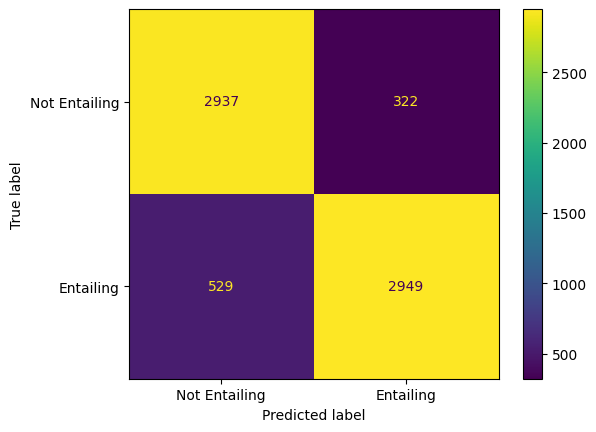

In [27]:
#Confusion matrix
conf_mat = draw_confusion_matrix(true_labels=true, predicted_logits=np.array(predicted_logits))

In [28]:
#Show the most confused samples
df = most_confused_samples(true_logits=to_categorical(true), predicted_logits=np.array(predicted_logits), premises=premises_og, hypotheses=hypotheses_og, num=10)
df

,Premise,Hypothesis,Loss,Predicted Label,True Label
0,Mon Dieu!,This person is speaking English.,16.118095,1,0
1,A lady wearing a red and white polka dot swim ...,Woman sits on the sidelines of a basketball game.,16.118095,0,0
2,but i don't know that's the bad thing there is...,The lawn is very beautiful as we have kept it ...,16.118095,0,1
3,you know it's it's not easy to do but,It's worth it in the end.,16.118095,1,1
4,"However, some of them indicated that certain I...",The indicated practices were all recorded.,16.118095,0,1
5,I Know He Grabbed Her,He grabbed her and threw her to the floor.,16.118095,1,1
6,A cute puppy fetches a yellow ring chew toy in...,A puppy plays fetch.,16.118095,1,1
7,It would be unnecessary to have two cars waiti...,It is imperative that I have two cars waiting ...,16.118095,0,0
8,Turn right at the end down Via Cappello for th...,Juliet did not really live in the palazzo.,16.118095,0,1
9,"'Wait here,' I was ordered.",He told me to wait until he opened the gate.,16.118095,1,1
